<a href="https://colab.research.google.com/github/tokaalaa/DM_Course/blob/main/Modulation_Classification_derivative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
import numpy as np
%matplotlib inline
import os,random
import keras.models as models
import matplotlib.pyplot as plt
import _pickle as cPickle
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,Reshape,Dropout,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras import metrics
from pandas import DataFrame as df
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Get Data

In [ ]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
!mv 'RML2016.10b.tar.bz2' '../content/drive/MyDrive/DM_4/Data/'
!bunzip2 '../content/drive/MyDrive/DM_4/Data/RML2016.10b.tar.bz2' 

#load data

In [ ]:
!tar -xf '../content/drive/MyDrive/DM_4/Data/RML2016.10b.tar'
!mv 'RML2016.10b.dat' '../content/drive/MyDrive/DM_4/Data/'
!mv 'LICENSE.TXT' '../content/drive/MyDrive/DM_4/Data/'

In [ ]:
# Load the dataset
file = open("../content/drive/MyDrive/DM_4/Data/RML2016.10b.dat",'rb')
Xd = cPickle.load(file, encoding = 'latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()


In [ ]:
print(X.shape)
X.shape[1:]

(1200000, 2, 128)


(2, 128)

In [ ]:
#input shape is (2, 128)
in_shp = list(X.shape[1:])

# num exist classes
classes = mods
print(mods, len(mods))

#first feature
print( X[:,0].shape)
#second feature
print( X[:,1].shape)

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] 10
(1200000, 128)
(1200000, 128)


#Create Features Space

In [ ]:
features = {}

#Raw Time Feature
features['raw'] = X[:,0], X[:,1]

#First derivative in time
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

#Integral in time
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

#combinations of 1,2 and 3
def extract_features(*arguments):
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    return np.stack(desired, axis = 1)

#Split data into training/validation and testing
    ○ Split the data into 70% for training/validation and 30% for testing.
    ○ Use 5% of the training and validation dataset for validation.


In [ ]:
#choose features
#data = extract_features('raw','integral')
data = extract_features('derivative')
labels = np.array(lbl)
print("data shape ", data.shape)
print("labels shape ", labels.shape)
print("data ", data)
print("labels ", labels)

#data shuffling & splitting
np.random.seed(10)
n_examples = labels.shape[0]
r = np.random.choice(range(n_examples), n_examples, replace = False)

num_training = n_examples*0.7
train_examples = r[:int(num_training)]
test_examples =  r[int(num_training):]
print("train_examples ", len(train_examples))
print("test_examples ", len(test_examples))

X_train = data[train_examples]
X_test = data[test_examples]

#labal as 1 at the spacific class which get from first column of label
y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

#labal as SNR which get from second column of label
snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

print(y_train.shape)
print(snr_train.shape)


data shape  (1200000, 2, 128)
labels shape  (1200000, 2)
data  [[[-0.06029993 -0.12386337 -0.01638079 ... -0.0186449   0.06209905
    0.09457203]
  [ 0.16911437  0.06956524 -0.03776356 ... -0.23020586 -0.01270726
   -0.0005663 ]]

 [[-0.13455155 -0.02764083  0.00650999 ... -0.0411226   0.04050773
   -0.05447972]
  [-0.34514645 -0.07355688  0.1361285  ... -0.02114303  0.03702613
    0.12621552]]

 [[-0.18550996 -0.00250622 -0.02935102 ...  0.06251812  0.2549248
    0.3008204 ]
  [-0.0445585   0.00260127  0.01163624 ... -0.06970791  0.01158406
    0.06449288]]

 ...

 [[-0.16397211 -0.15072271  0.05715781 ...  0.08676518 -0.01242725
    0.01578163]
  [-0.04016563 -0.06004853  0.07957528 ... -0.00850576  0.09017439
    0.11593006]]

 [[-0.11283428  0.02968843  0.05834858 ...  0.00151971 -0.01446231
   -0.05903269]
  [ 0.01565286 -0.03616421 -0.0380171  ...  0.02515107 -0.08338179
   -0.02031115]]

 [[-0.00847177  0.05038936  0.05964413 ...  0.05492792 -0.01224817
   -0.05917422]
  [-0.112

#Model fully connected dense layer

In [ ]:
def full_connected_model(in_shape):
  # Declare layers size
  hidden1_size = 512
  hidden2_size = 256
  hidden3_size = 10

  # Build model
  model = Sequential()
  model.add(Dense(hidden1_size, input_shape = in_shape, activation ='relu'))
  model.add(Dense(hidden2_size, activation ='relu'))
  model.add(Flatten())
  model.add(Dense(hidden3_size, activation ='softmax'))

  # Compile model
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
  model.summary()
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 512)            66048     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 5s 6ms/step - loss: 2.0686 - accuracy: 0.2208 - val_loss: 1.8773 - val_accuracy: 0.2925

Epoch 00001: val_accuracy improved from -inf to 0.29255, saving model to ../content/drive/MyDrive/DM_4/f

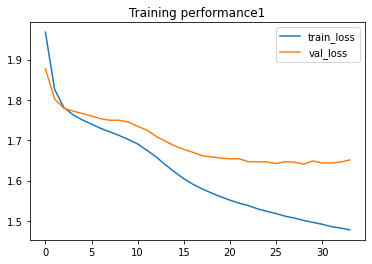

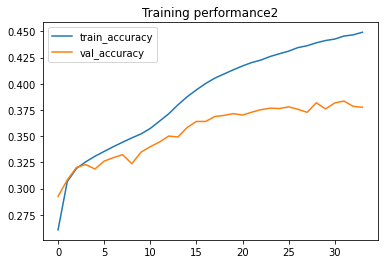

In [ ]:
def train_full_connected_model(X_train, y_train, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  train_history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.05, batch_size = 2048, callbacks=[es,mc])

  # Show loss curves
  # this is both on training and validation data, hence two curves. They track well.
  plt.figure()
  plt.title('Training performance1')
  plt.plot(train_history.epoch, train_history.history['loss'], label='train_loss')
  plt.plot(train_history.epoch, train_history.history['val_loss'], label='val_loss')
  plt.legend()

  plt.figure()
  plt.title('Training performance2')
  plt.plot(train_history.epoch, train_history.history['accuracy'], label='train_accuracy')
  plt.plot(train_history.epoch, train_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

train_full_connected_model(X_train, y_train, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_derivative.h5', 100)


#Test of fully connected

In [ ]:
def test_full_connected_model(X_test, y_test, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  score = model.evaluate(X_test, y_test, verbose=0, batch_size=2048)
  print(score)

test_full_connected_model(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_derivative.h5', 100)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_4 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
[1.6407184600830078, 0.3845277726650238]


#Plots of the accuracy against the SNR 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 512)            66048     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________


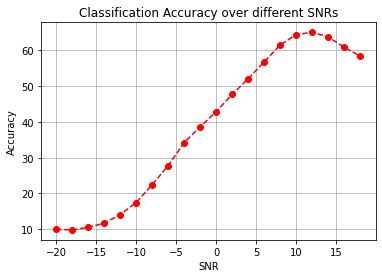

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)
batch_size = 1024
model = full_connected_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/fully_connected_derivative.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/fully_connected_derivative.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

plot_results(y_pred_FC, y_test, snr_test)

#Report the average overall accuracy as well as the results at SNR=0dB

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

model = full_connected_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/fully_connected_derivative.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/fully_connected_derivative.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

print_results(y_pred_FC, y_test, snr_test)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_4 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.0,9.83,10.54,11.7,14.07,17.48,22.44,27.78,34.19,38.64,42.87,47.67,52.05,56.77,61.49,64.37,65.01,63.67,60.78,58.3


#confusion matrices and find the most confusing classes

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_7 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
[[0.17106694 0.20126014 0.06417798 0.04990382 0.01720148 0.07580362
  0.1103181  0.13646882 0.08826563 0.08553347]
 [0.01594167 0.57947268 0.03116249 0.03751144 0.04416535 0.02212426
  0.0077629  0.00332696 0.01283651 0.24569575]
 [0.03623754 0.1

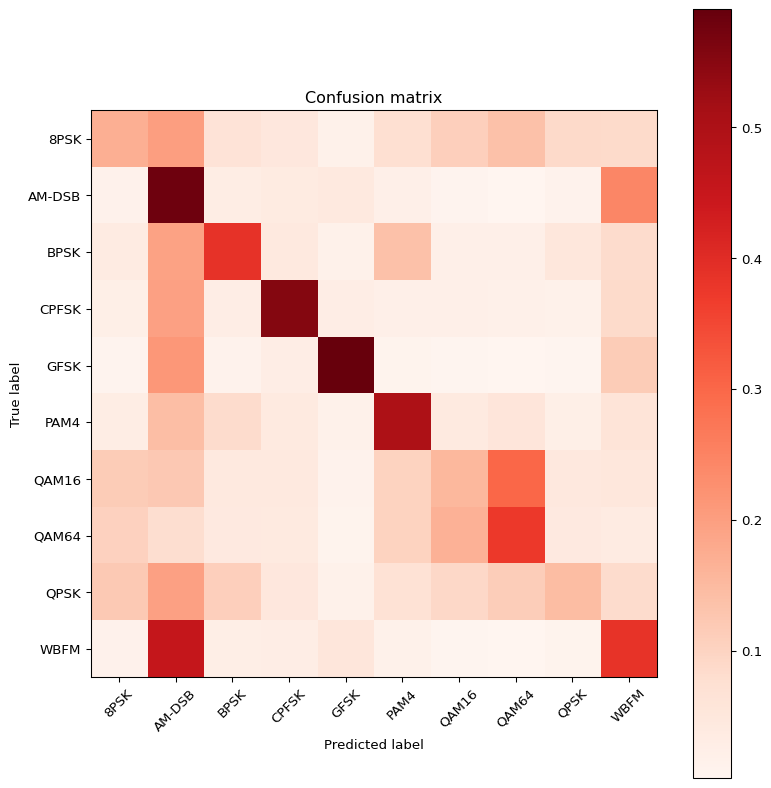

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
batch_size = 1024  # training batch size
# Plot confusion matrix
def Plot_confusion(X_test, y_test, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  # Show simple version of performance
  test_Y_hat = model.predict(X_test, batch_size=batch_size)
  #fill matrices with zeros
  conf = np.zeros([len(classes),len(classes)])
  #normalize confusion matrix
  confnorm = np.zeros([len(classes),len(classes)])
 
  #this puts all the data into an 11 x 11 matrix for plotting.
  for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
  #takes the data to plot and normalizes it
  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  print (confnorm)
  print (classes)
  plot_confusion_matrix(confnorm, labels=classes)

Plot_confusion(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_derivative.h5', 100)


#Model CNN

In [ ]:
def cnn_model(in_shape):
  conv1_kernel_shape=(3,1)
  conv1_number_of_filters=64
  conv2_kernel_shape=(3,2)
  conv2_number_of_filters=16
  dense1_size = 128
  dense2_size = 10
  dropout = 0.4

  # Build model
  model_conv = Sequential()
  model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
  model_conv.add(Conv2D(conv1_number_of_filters, conv1_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu'))
  model_conv.add(BatchNormalization())
  model_conv.add(MaxPooling2D())
  model_conv.add(Conv2D(conv2_number_of_filters, conv2_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu'))
  model_conv.add(Flatten())
  model_conv.add(Dropout(rate=1-dropout))
  model_conv.add(Dense(dense1_size, activation='relu'))
  model_conv.add(Dense(dense2_size, activation='softmax'))

  # Compile model
  model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_conv.summary()
  return model_conv

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)             

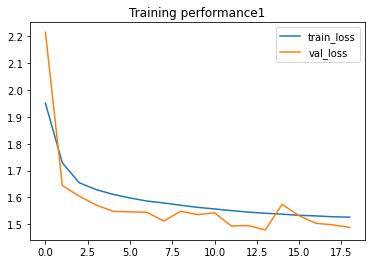

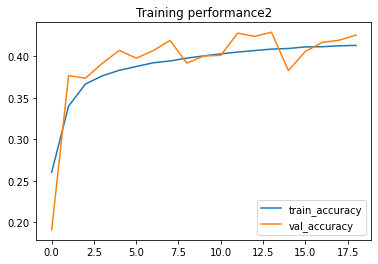

In [ ]:
def train_cnn_model(X_train, y_train, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  train_history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.05, batch_size = 2048, callbacks=[es,mc])

  # Show loss curves
  plt.figure()
  plt.title('Training performance1')
  plt.plot(train_history.epoch, train_history.history['loss'], label='train_loss')
  plt.plot(train_history.epoch, train_history.history['val_loss'], label='val_loss')
  plt.legend()

  # Show accuracy curves
  plt.figure()
  plt.title('Training performance2')
  plt.plot(train_history.epoch, train_history.history['accuracy'], label='train_accuracy')
  plt.plot(train_history.epoch, train_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

train_cnn_model(X_train, y_train, (2,128), '../content/drive/MyDrive/DM_4/CNN_derivative.h5', 100)


#Test of CNN

In [ ]:
def test_cnn_model(X_test, y_test, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  score = model.evaluate(X_test, y_test, verbose=0, batch_size=2048)
  print(score)

test_cnn_model(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/CNN_derivative.h5', 100)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

#Plots of the accuracy against the SNR 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

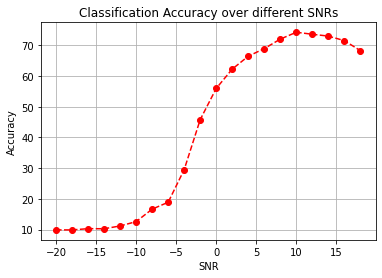

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

model = cnn_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/CNN_derivative.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/CNN_derivative.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

plot_results(y_pred_FC, y_test, snr_test)

#Report the average overall accuracy as well as the results at SNR=0dB

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

model = cnn_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/CNN_derivative.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/CNN_derivative.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

print_results(y_pred_FC, y_test, snr_test)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,9.89,9.88,10.28,10.26,11.17,12.58,16.64,18.89,29.51,45.8,55.96,62.24,66.44,68.91,72.01,74.24,73.58,72.98,71.5,68.24


#confusion matrices and find the most confusing classes

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

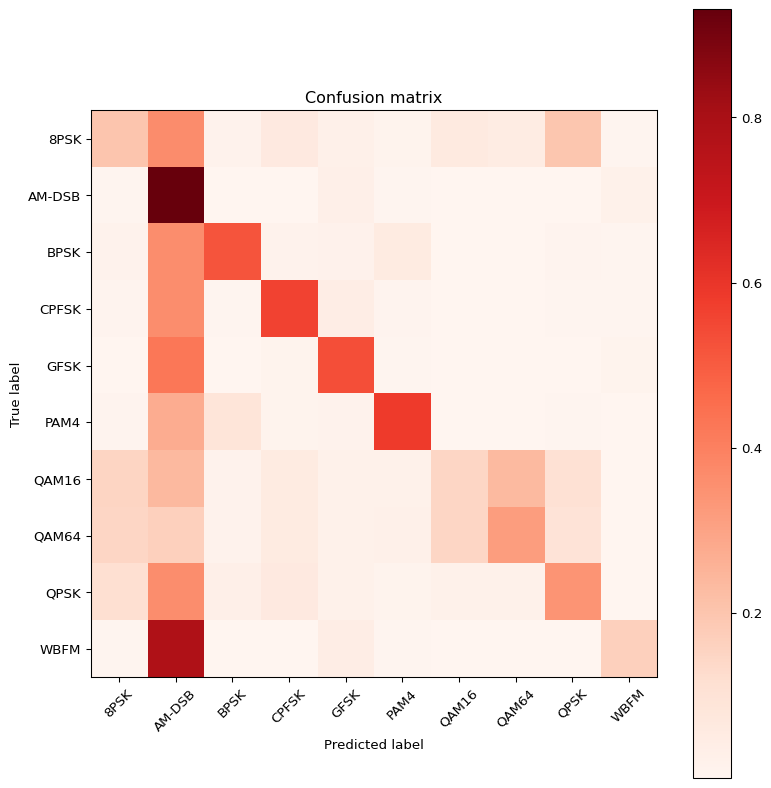

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
batch_size = 1024  # training batch size
# Plot confusion matrix
def Plot_confusion(X_test, y_test, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  # Show simple version of performance
  test_Y_hat = model.predict(X_test, batch_size=batch_size)
  #fill matrices with zeros
  conf = np.zeros([len(classes),len(classes)])
  #normalize confusion matrix
  confnorm = np.zeros([len(classes),len(classes)])
 
  #this puts all the data into an 11 x 11 matrix for plotting.
  for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
  #takes the data to plot and normalizes it
  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  print (confnorm)
  print (classes)
  plot_confusion_matrix(confnorm, labels=classes)

Plot_confusion(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/CNN_derivative.h5', 100)


#Model Logistic Regression Classifier

In [ ]:
y_train_convert = []
for y in y_train:
  maximum = np.max(y)
  index_of_maximum = np.where(y == maximum)
  y_train_convert.append(index_of_maximum)

y_test_convert = []
for y in y_test:
  maximum = np.max(y)
  index_of_maximum = np.where(y == maximum)
  y_test_convert.append(index_of_maximum)

In [ ]:
from sklearn.linear_model import LogisticRegression
print(X_train.shape)
print(snr_train.shape)
# Create an instance of the scaler and apply it to the data
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

y_train_convert = np.squeeze(y_train_convert) 
y_test_convert = np.squeeze(y_test_convert)
print(y_train_convert.shape)
print(y_test_convert.shape)

LogReg_clf = LogisticRegression()
lrcModel = LogReg_clf.fit(d2_train_dataset, y_train_convert)


y_pred_lrcModel = lrcModel.predict(d2_test_dataset)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_convert, y_pred_lrcModel))
print(confusion_matrix(y_test_convert, y_pred_lrcModel))
print(metrics.classification_report(y_test_convert, y_pred_lrcModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

(840000, 2, 128)
(840000,)
(840000,)
(360000,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.11668055555555555
[[3798 3543 3734 4102 3188 3487 3585 3601 3011 3820]
 [4060 5296 3536 3733 3425 3112 2431 2409 3196 4871]
 [3805 3704 3742 4122 3151 3445 3319 3624 3228 3762]
 [3965 3942 3488 4248 3605 3137 3083 3143 3013 4249]
 [3821 4410 3136 3964 4723 2615 2417 2939 3273 4953]
 [3701 3417 3912 4154 3134 3423 3627 3932 3180 3520]
 [3823 2884 3604 4536 3124 3589 3969 4171 2997 3466]
 [3692 2539 3687 4669 3046 3626 4139 4293 3021 3169]
 [3719 3614 3551 4285 3085 3529 3612 3604 3180 3734]
 [4056 5026 3331 3523 3903 3030 2333 2502 3042 5333]]
              precision    recall  f1-score   support

        8PSK       0.10      0.11      0.10     35869
      AM-DSB       0.14      0.15      0.14     36069
        BPSK       0.10      0.10      0.10     35902
       CPFSK       0.10      0.12      0.11     35873
        GFSK       0.14      0.13      0.13     36251
        PAM4       0.10      0.10      0.10     36000
       QAM16       0.12      0.11      0.12     36163
      

In [ ]:
rows, cols = (360000, 10)
y_pred_lrcModel_convert = [[0 for i in range(cols)] for j in range(rows)] 
for i in range(360000):
  y_pred_lrcModel_convert[i][y_pred_lrcModel[i]] = 1

In [ ]:
print(y_pred_lrcModel_convert[0:5])
print(y_pred_lrcModel_convert[0][0])
print(y_pred_lrcModel[0:5])
y_pred_lrcModel_convert = np.array(y_pred_lrcModel_convert)
print(y_pred_lrcModel_convert.shape)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
0
[9 1 0 3 9]
(360000, 10)


#Evaluation

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)
batch_size = 1024
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.1058853  0.0987761  0.10410103 0.11436059 0.08887898 0.09721487
  0.09994703 0.1003931  0.08394435 0.10649865]
 [0.11256203 0.14682969 0.09803432 0.10349608 0.09495689 0.08627908
  0.0673986  0.06678866 0.08860795 0.13504672]
 [0.10598295 0.10316974 0.10422818 0.11481255 0.0877667  0.09595566
  0.0924461  0.10094145 0.08991143 0.10478525]
 [0.11052881 0.10988766 0.0972319  0.11841775 0.10049341 0.08744738
  0.08594207 0.08761464 0.08399075 0.11844563]
 [0.10540399 0.12165182 0.08650796 0.10934871 0.13028606 0.07213594
  0.06667402 0.08107363 0.09028716 0.13663071]
 [0.10280556 0.09491667 0.10866667 0.11538889 0.08705556 0.09508333
  0.10075    0.10922222 0.08833333 0.09777778]
 [0.10571579 0.07975002 0.09965987 0.12543207 0.08638664 0.09924508
  0.10975306 0.11533888 0.08287476 0.09584382]
 [0.10289568 0.07076168 0.10275633 0.13012458 0.08489173 0.10105627
  0.11535353 0.11964549 0.08419498 0.08831972]
 [0.10355582 0.10063208 0.09887784 0.11931613 0.08590204 0.09826525
  0.10057639

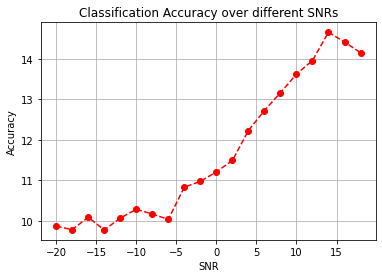

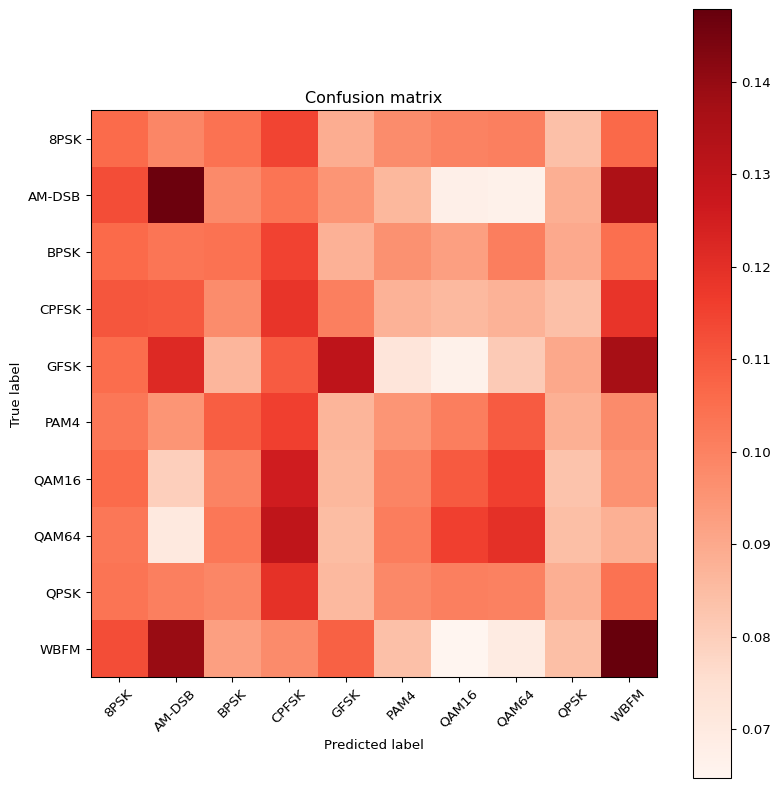

In [ ]:
plot_results(y_pred_lrcModel_convert, y_test, snr_test)
print_results(y_pred_lrcModel_convert, y_test, snr_test)

conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_lrcModel_convert[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
print_results(y_pred_lrcModel_convert, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,9.87,9.78,10.09,9.77,10.07,10.28,10.17,10.03,10.83,10.97,11.21,11.49,12.23,12.72,13.16,13.62,13.96,14.65,14.41,14.15


#Model Decision Tree 

In [ ]:
decisionTreeClassifier = DecisionTreeClassifier()
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))
decisionTreeClassifier.fit(d2_train_dataset, y_train)

nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))
y_pred_dtcModel = decisionTreeClassifier.predict(d2_test_dataset)


In [ ]:
# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dtcModel))
print(confusion_matrix(y_test.argmax(axis=1), y_pred_dtcModel.argmax(axis=1)))
print(metrics.classification_report(y_test, y_pred_dtcModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

Accuracy: 0.17616944444444443
[[ 4313  3341  3158  2849  2936  2988  4444  4479  4151  3210]
 [ 3340  5600  3392  3474  4016  2943  2580  2217  3343  5164]
 [ 3150  3482  6473  2703  2986  5034  2870  2666  3242  3296]
 [ 2947  3329  2639 10392  3123  2415  2597  2318  2831  3282]
 [ 3147  4136  2969  3264  7423  2692  2866  2609  3016  4129]
 [ 3042  3042  5107  2421  2626  7722  3085  3098  2960  2897]
 [ 4433  2585  2883  2466  2762  3151  5183  5724  4367  2609]
 [ 4655  2169  2716  2265  2533  3127  5582  6249  4392  2193]
 [ 4332  3338  3161  2832  2916  3021  4352  4316  4450  3195]
 [ 3334  5269  3376  3260  4188  2938  2587  2315  3196  5616]]
              precision    recall  f1-score   support

        8PSK       0.12      0.12      0.12     35869
      AM-DSB       0.15      0.16      0.15     36069
        BPSK       0.18      0.18      0.18     35902
       CPFSK       0.29      0.29      0.29     35873
        GFSK       0.21      0.20      0.21     36251
        PAM4  

#Evaluation

[[0.12024311 0.0931445  0.0880426  0.07942792 0.08185341 0.08330313
  0.12389529 0.12487106 0.11572667 0.08949232]
 [0.09260029 0.15525798 0.09404198 0.0963154  0.11134215 0.08159361
  0.07152957 0.06146552 0.09268347 0.14317004]
 [0.08773884 0.09698624 0.18029636 0.07528828 0.08317085 0.14021503
  0.07993984 0.0742577  0.09030138 0.09180547]
 [0.08215092 0.0927996  0.07356508 0.28968862 0.08705712 0.06732083
  0.07239428 0.06461684 0.07891729 0.09148942]
 [0.0868114  0.1140934  0.08190119 0.0900389  0.20476677 0.07426002
  0.07905989 0.07197043 0.0831977  0.11390031]
 [0.0845     0.0845     0.14186111 0.06725    0.07294444 0.2145
  0.08569444 0.08605556 0.08222222 0.08047222]
 [0.12258386 0.0714819  0.07972237 0.06819125 0.07637641 0.08713326
  0.14332329 0.15828333 0.12075879 0.07214556]
 [0.1297344  0.06044982 0.07569466 0.06312533 0.07059447 0.08714919
  0.1555698  0.17415903 0.12240462 0.0611187 ]
 [0.12062484 0.09294684 0.08801827 0.07885724 0.08119622 0.08411996
  0.12118174 0.1

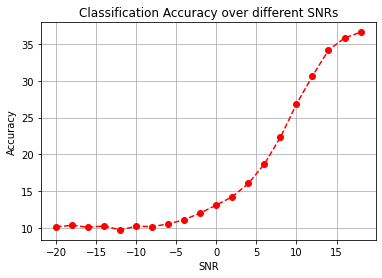

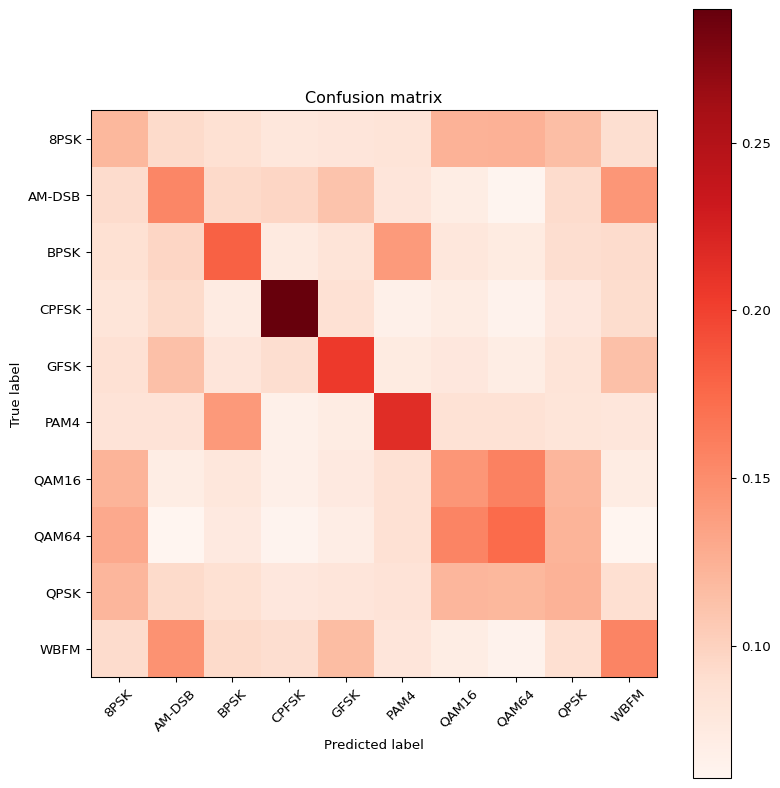

In [ ]:
plot_results(y_pred_dtcModel, y_test, snr_test)
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_dtcModel[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
print_results(y_pred_dtcModel, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.13,10.33,10.07,10.24,9.71,10.21,10.15,10.52,11.09,12.02,13.09,14.24,16.03,18.68,22.33,26.83,30.67,34.18,35.84,36.62


#Model Random Forest

In [ ]:
X_train = data[train_examples]
X_test = data[test_examples]

#labal as 1 at the spacific class which get from first column of label
y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

#labal as SNR which get from second column of label
snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

print(y_train.shape)
print(snr_train.shape)


In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,n_jobs = 1)
nsamples, nx, ny = data[train_examples].shape
#d2_train_dataset = data[train_examples].reshape((nsamples,nx*ny))
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(data[train_examples].reshape((nsamples,nx*ny)), LB().fit_transform(labels[train_examples][:,0]))

nsamples, nx, ny = data[test_examples].shape
#d2_test_dataset = data[test_examples].reshape((nsamples,nx*ny))
y_pred_mrfModel = clf.predict(data[test_examples].reshape((nsamples,nx*ny)))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(LB().fit_transform(labels[test_examples][:,0]), y_pred_mrfModel))
print(confusion_matrix(LB().fit_transform(labels[test_examples][:,0]).argmax(axis=1), y_pred_mrfModel.argmax(axis=1)))
print(metrics.classification_report(LB().fit_transform(labels[test_examples][:,0]), y_pred_mrfModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

#Evaluation

In [ ]:
plot_results(y_pred_mrfModel, LB().fit_transform(labels[test_examples][:,0]), labels[test_examples][:,1].astype(int))
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,data[test_examples].shape[0]):
    # j is first value in list
    j = list(LB().fit_transform(labels[test_examples][:,0])[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_mrfModel[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
print_results(y_pred_mrfModel, LB().fit_transform(labels[test_examples][:,0]), labels[test_examples][:,1].astype(int))